# Maximum Sharpe ratio portfolio on selected Danish stocks

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from port_opt import get_portf_rtn, get_portf_vol, get_optimal_portfolio, get_efficient_frontier, neg_sharpe_ratio

In [2]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('cubehelix')
plt.rcParams['figure.figsize'] = [5.5, 3]
plt.rcParams['figure.dpi'] = 200

np.random.seed(0)

## Load the preprocessed data

To see how the input has been processed and why go to see the [Input data preparation notebook](./input_data_preparation.ipynb)

In [3]:
%run preprocessing.py -n DK -i stock

In [5]:
mu = np.load('..\data\DK\preprocessed_data\stocks\m.npy')
cov = np.load('..\data\DK\preprocessed_data\stocks\S.npy')

In [6]:
close_df = pd.read_csv('..\data\DK\preprocessed_data\danish_closed_stocks.csv', index_col=0)

In [7]:
# Constants
danish_2y_yield = 0.03463
stocks_names = close_df.columns.tolist()

## Portfolio optimization

In [8]:
n_days = 260
n_portfolios = 100_000
n_assets = len(mu)

In [9]:
weights = np.random.random(size=(n_portfolios, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

In [10]:
portf_rtns = np.dot(weights, mu)

portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(np.dot(weights[i].T, 
                                    np.dot(cov, weights[i]))))
portf_vol = np.array(portf_vol)  
portf_sharpe_ratio = (portf_rtns - danish_2y_yield) / portf_vol

In [11]:
portf_results_df = pd.DataFrame({'returns': portf_rtns,
                                 'volatility': portf_vol,
                                 'sharpe_ratio': portf_sharpe_ratio})

In [12]:
n_points = 100
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), 
                            portf_results_df.returns.max(), 
                           n_points)
portf_rtns_ef = np.round(portf_rtns_ef, 2)    
portf_rtns = np.round(portf_rtns, 2)

for point_index in range(n_points):
    if portf_rtns_ef[point_index] not in portf_rtns:
        indices_to_skip.append(point_index)
        continue
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index])
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))
    
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

C:\Users\paolo\AppData\Local\Temp\ipykernel_23200\2010160098.py:22: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


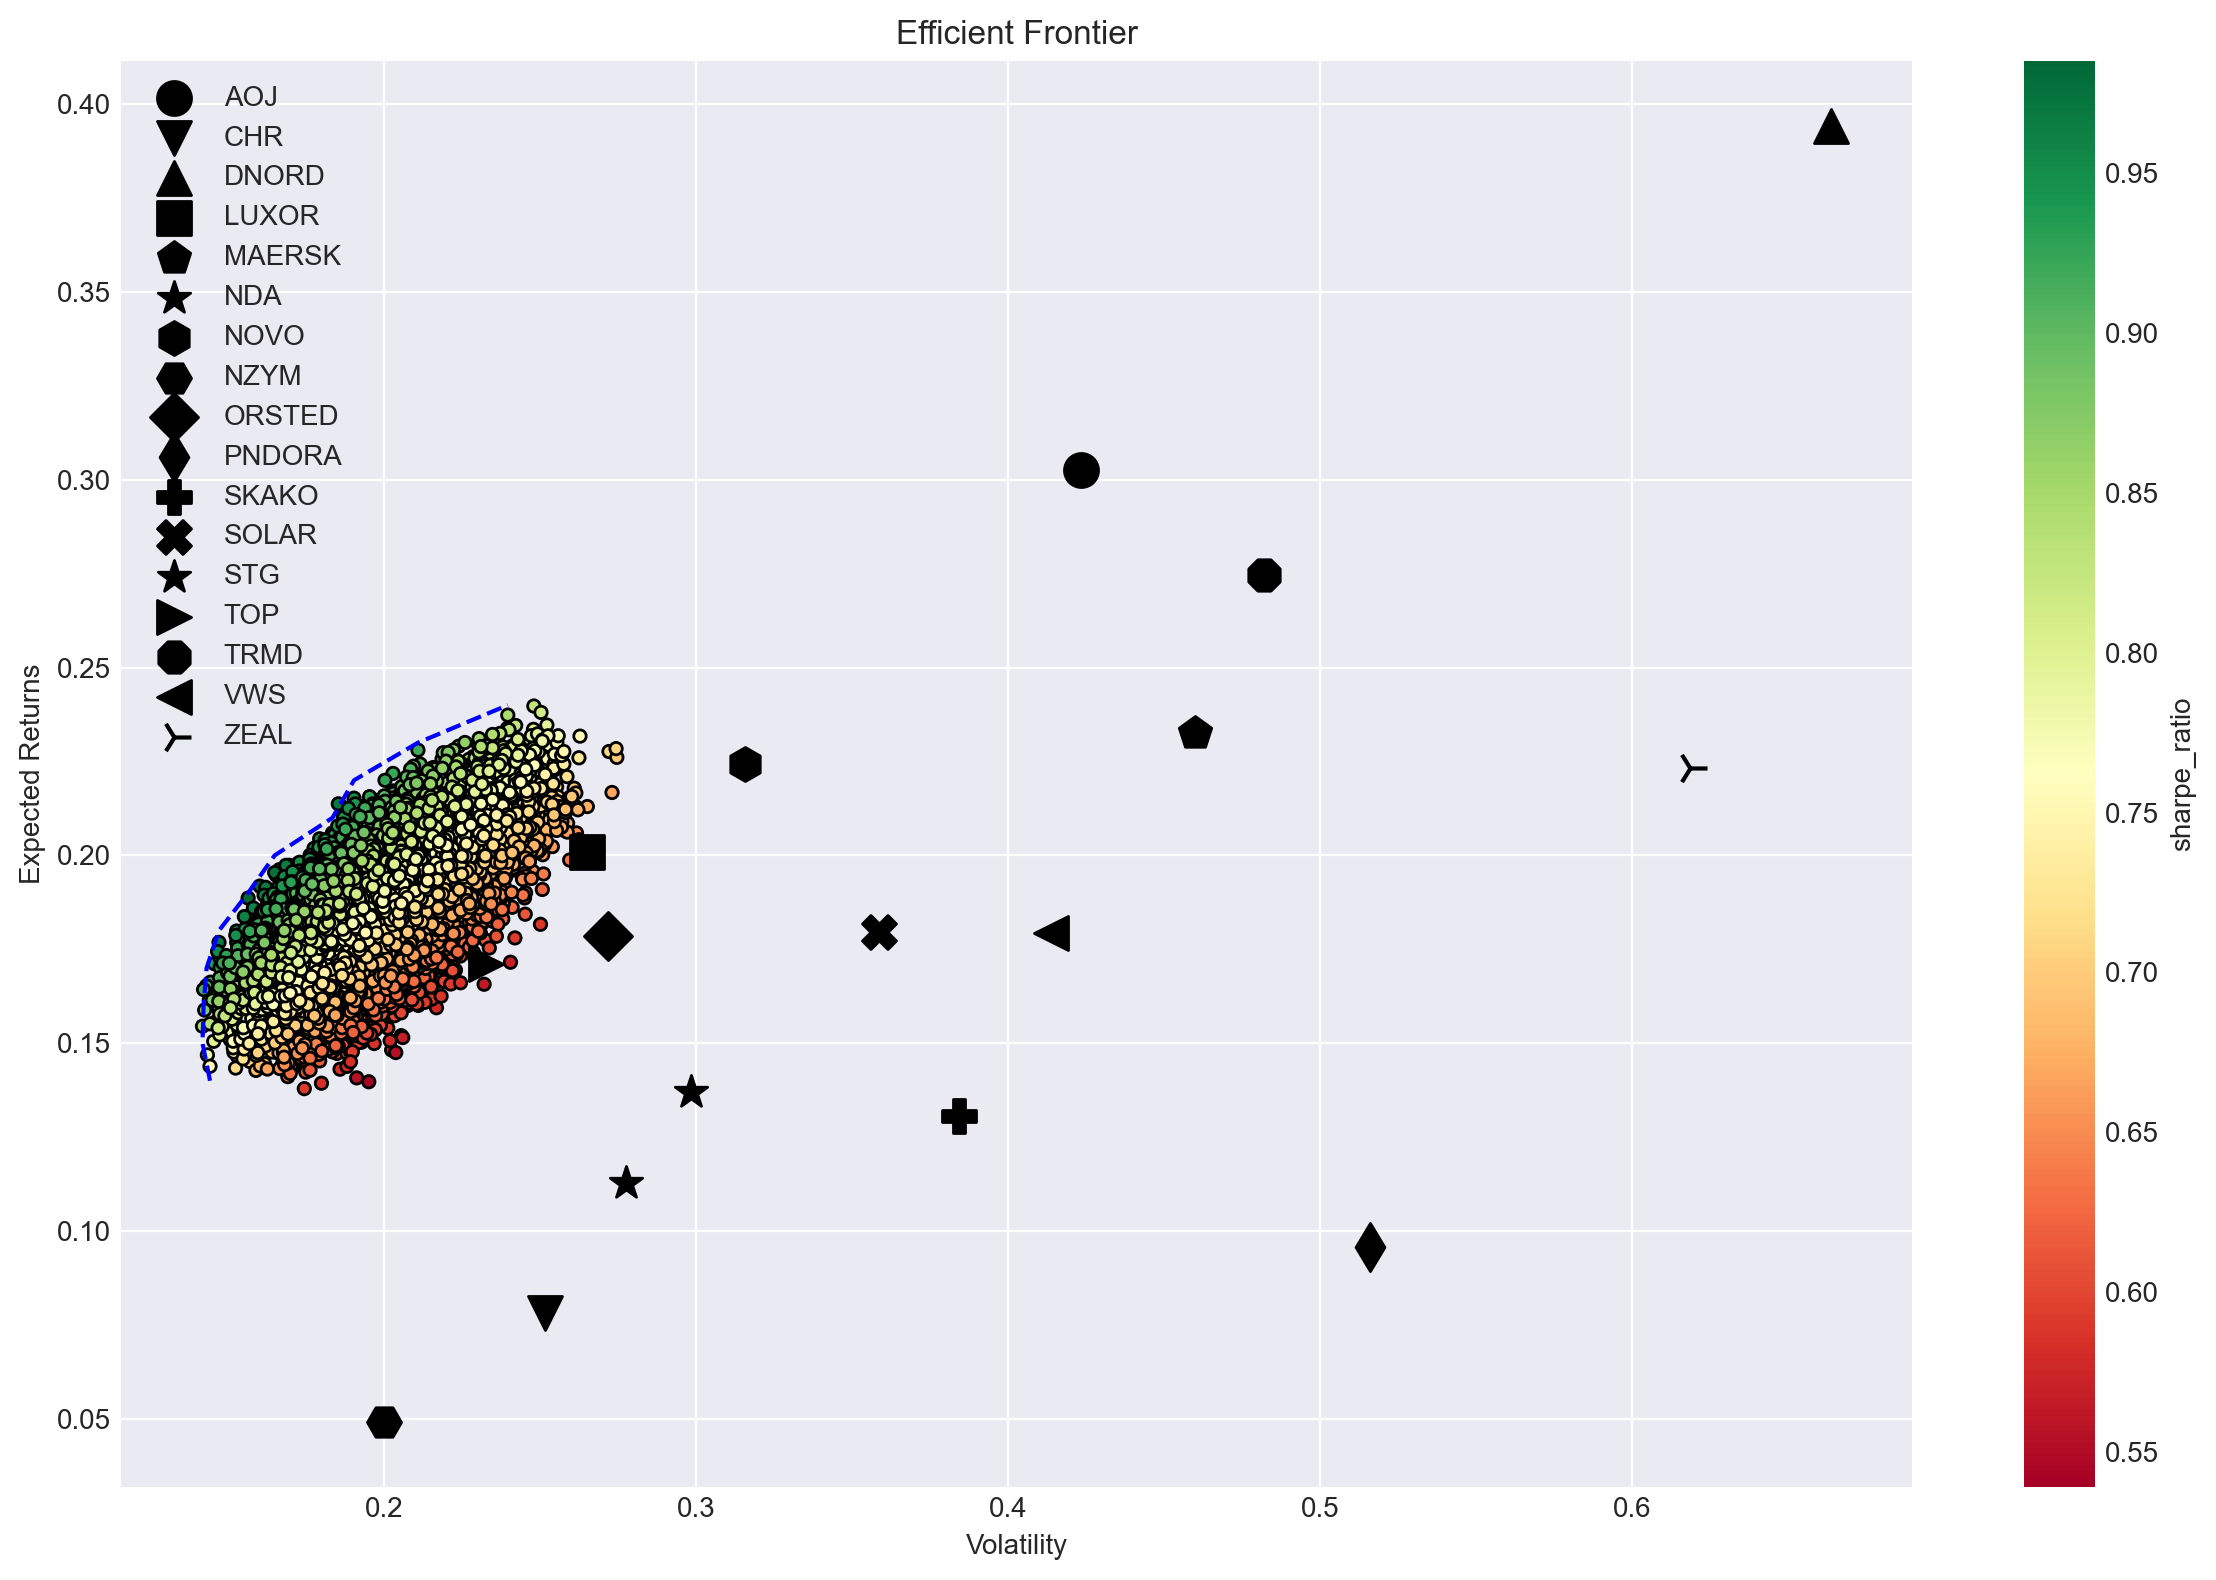

In [13]:
MARKS = ['o', 'v', '^', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X', '*', 
         '>', '8', '<', '4']

fig, ax = plt.subplots(figsize=(12, 8))
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov[asset_index, asset_index]), 
                y=mu[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='black',
                label=stocks_names[asset_index])
ax.legend()

plt.tight_layout()
plt.show()

### Max sharpe ratio portfolio

Let's now find the *Maximum Sharpe Ration Portfolio* which is the portfolio with maximum sharpe ratio. This portfolio can be obtained solving the following non linear program:

$$
\begin{align}
\min_{w} & - \frac{\boldsymbol w^T \boldsymbol \mu - r_f}{\sqrt{\boldsymbol w^T C \boldsymbol w}}  &\\
\text{s.t.: } & \sum_{i=1}^N w_i = 1 \\
& w_i \ge 0 & \forall i \in \{1, \cdots, N\}
\end{align}
$$

In [14]:
RF_RATE = danish_2y_yield
args = (mu, cov, RF_RATE)
constraints = ({'type': 'eq',
                'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0,1) for asset in range(n_assets))
max_sharpe_portf = get_optimal_portfolio(f_obj=neg_sharpe_ratio,
                                        args=args,
                                        constraints=constraints,
                                        bounds=bounds)

In [15]:
max_sharpe_portf_w = max_sharpe_portf['x']
max_sharpe_portf = {'Return': get_portf_rtn(max_sharpe_portf_w,
                                            mu),
                    'Volatility': get_portf_vol(max_sharpe_portf_w,
                                                mu,
                                                cov),
                    'Sharpe Ratio': -max_sharpe_portf['fun']}

In [16]:
rtns_range = np.linspace(-0.22, 0.50, 200)

In [17]:
efficient_portfolios = get_efficient_frontier(mu, 
                                              cov, 
                                              rtns_range)

In [18]:
vols_range = [x['fun'] for x in efficient_portfolios]

In [19]:
min_vol_ind = np.argmin(vols_range)
min_vol_portf_rtn = rtns_range[min_vol_ind]
min_vol_portf_vol = efficient_portfolios[min_vol_ind]['fun']

min_vol_portf = {'Return': min_vol_portf_rtn,
                 'Volatility': min_vol_portf_vol,
                 'Sharpe Ratio': ((min_vol_portf_rtn - danish_2y_yield) / 
                                  min_vol_portf_vol)}

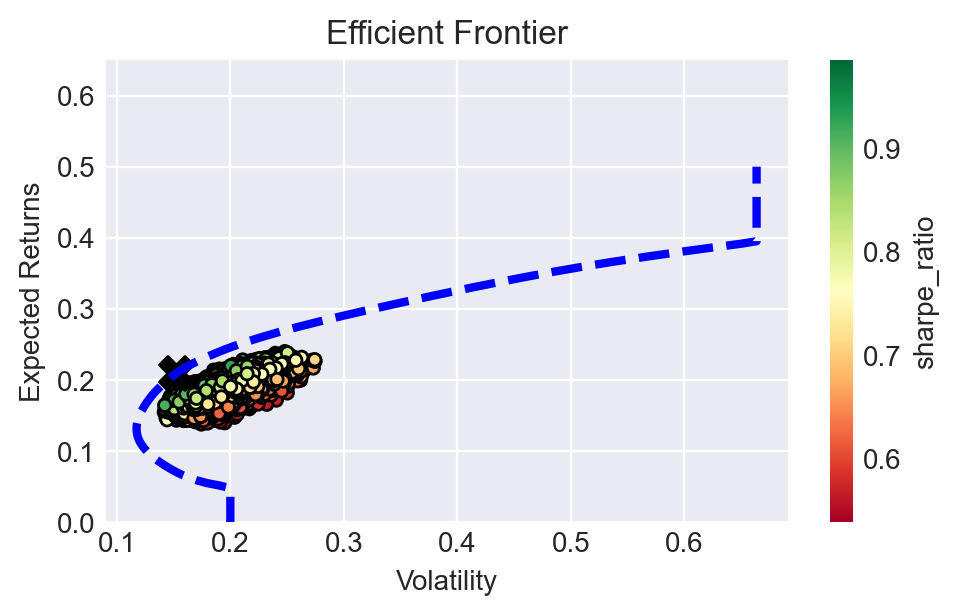

In [20]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility',
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black',
                      ax=ax)
ax.plot(vols_range, rtns_range, 'b--', linewidth=3)
ax.set(xlabel='Volatility',
       ylabel='Expected Returns',
       title='Efficient Frontier')
ax.scatter(x=max_sharpe_portf['Volatility'],
                y=max_sharpe_portf['Return'],
                marker='X',
                s=150,
                color='black',
                label='MSR')

plt.ylim(0.00,0.65)
plt.show()

In [21]:
print('Maximum Sharpe Ratio portfolio ----')
print('Performance')

for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)

print('\nWeights')
for x, y in zip(stocks_names, max_sharpe_portf_w):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
Return: 20.94% Volatility: 15.22% Sharpe Ratio: 114.78% 
Weights
AOJ: 10.97% CHR: 0.00% DNORD: 1.63% LUXOR: 31.74% MAERSK: 0.02% NDA: 0.00% NOVO: 16.68% NZYM: 0.00% ORSTED: 11.21% PNDORA: 0.00% SKAKO: 7.94% SOLAR: 0.00% STG: 0.00% TOP: 13.01% TRMD: 1.31% VWS: 0.00% ZEAL: 5.49% 